## load Datasets

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math

paths={}
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        directory=os.path.join(dirname, filename)
        name=filename.split(".")
        paths[name[0]]=directory
        

df_train=pd.read_csv(paths["train"])
df_test=pd.read_csv(paths["test"])
df_sub=pd.read_csv(paths["sample_submission"])

## EDA

In [2]:
df_train.sample(5)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
18947,18947,Male,25.113537,1.780089,114.511537,yes,yes,2.22259,3.000000,Sometimes,no,2.046766,no,1.156024,0.072264,Sometimes,Public_Transportation,Obesity_Type_II
19355,19355,Female,18.000000,1.600000,55.000000,yes,no,3.00000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Public_Transportation,Normal_Weight
12634,12634,Female,21.746113,1.700020,78.000000,yes,yes,2.00000,2.434347,Sometimes,no,1.879381,no,0.000000,1.944177,Frequently,Public_Transportation,Overweight_Level_II
13830,13830,Male,18.000000,1.843420,52.629374,no,yes,3.00000,3.000000,Sometimes,no,2.099863,no,0.000000,1.592570,Sometimes,Public_Transportation,Insufficient_Weight
14422,14422,Female,22.000000,1.630000,58.000000,yes,yes,1.00000,3.000000,Sometimes,no,1.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight


In [3]:
df_train["NObeyesdad"].unique()

array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight',
       'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I',
       'Obesity_Type_I'], dtype=object)

Notice that labels does not come in a particular order. to gain insight on progressive and scale nature of obesity risk. it is necessary to preserve contigency of obesity risk which in our case is about severity.

from WHO, definition of obesity: Overweight and obesity are defined as abnormal or excessive fat accumulation that presents a risk to health. 

- We use domain knowledge to know the order. by heuristics, we know Obesity is associated with weight due to association of eright with fat accumulation. so we can preserve order provided by Weight.

- note that Weight alone does not predict Obesity. but it provides ground point for contigency.

- PS: It make sense to have Overweight near Obesity_type_II than Insufficient_weight near Obesity_type_II. 



In [4]:
# Calculate mean weight for each category of obesity risk
mean_weights = df_train.groupby("NObeyesdad")['Weight'].mean().sort_values().index.tolist()
mean_weights

['Insufficient_Weight',
 'Normal_Weight',
 'Overweight_Level_I',
 'Overweight_Level_II',
 'Obesity_Type_I',
 'Obesity_Type_II',
 'Obesity_Type_III']

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [6]:
df_train.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Height'}>,
        <Axes: title={'center': 'Weight'}>],
       [<Axes: title={'center': 'FCVC'}>,
        <Axes: title={'center': 'NCP'}>,
        <Axes: title={'center': 'CH2O'}>],
       [<Axes: title={'center': 'FAF'}>, <Axes: title={'center': 'TUE'}>,
        <Axes: >]], dtype=object)

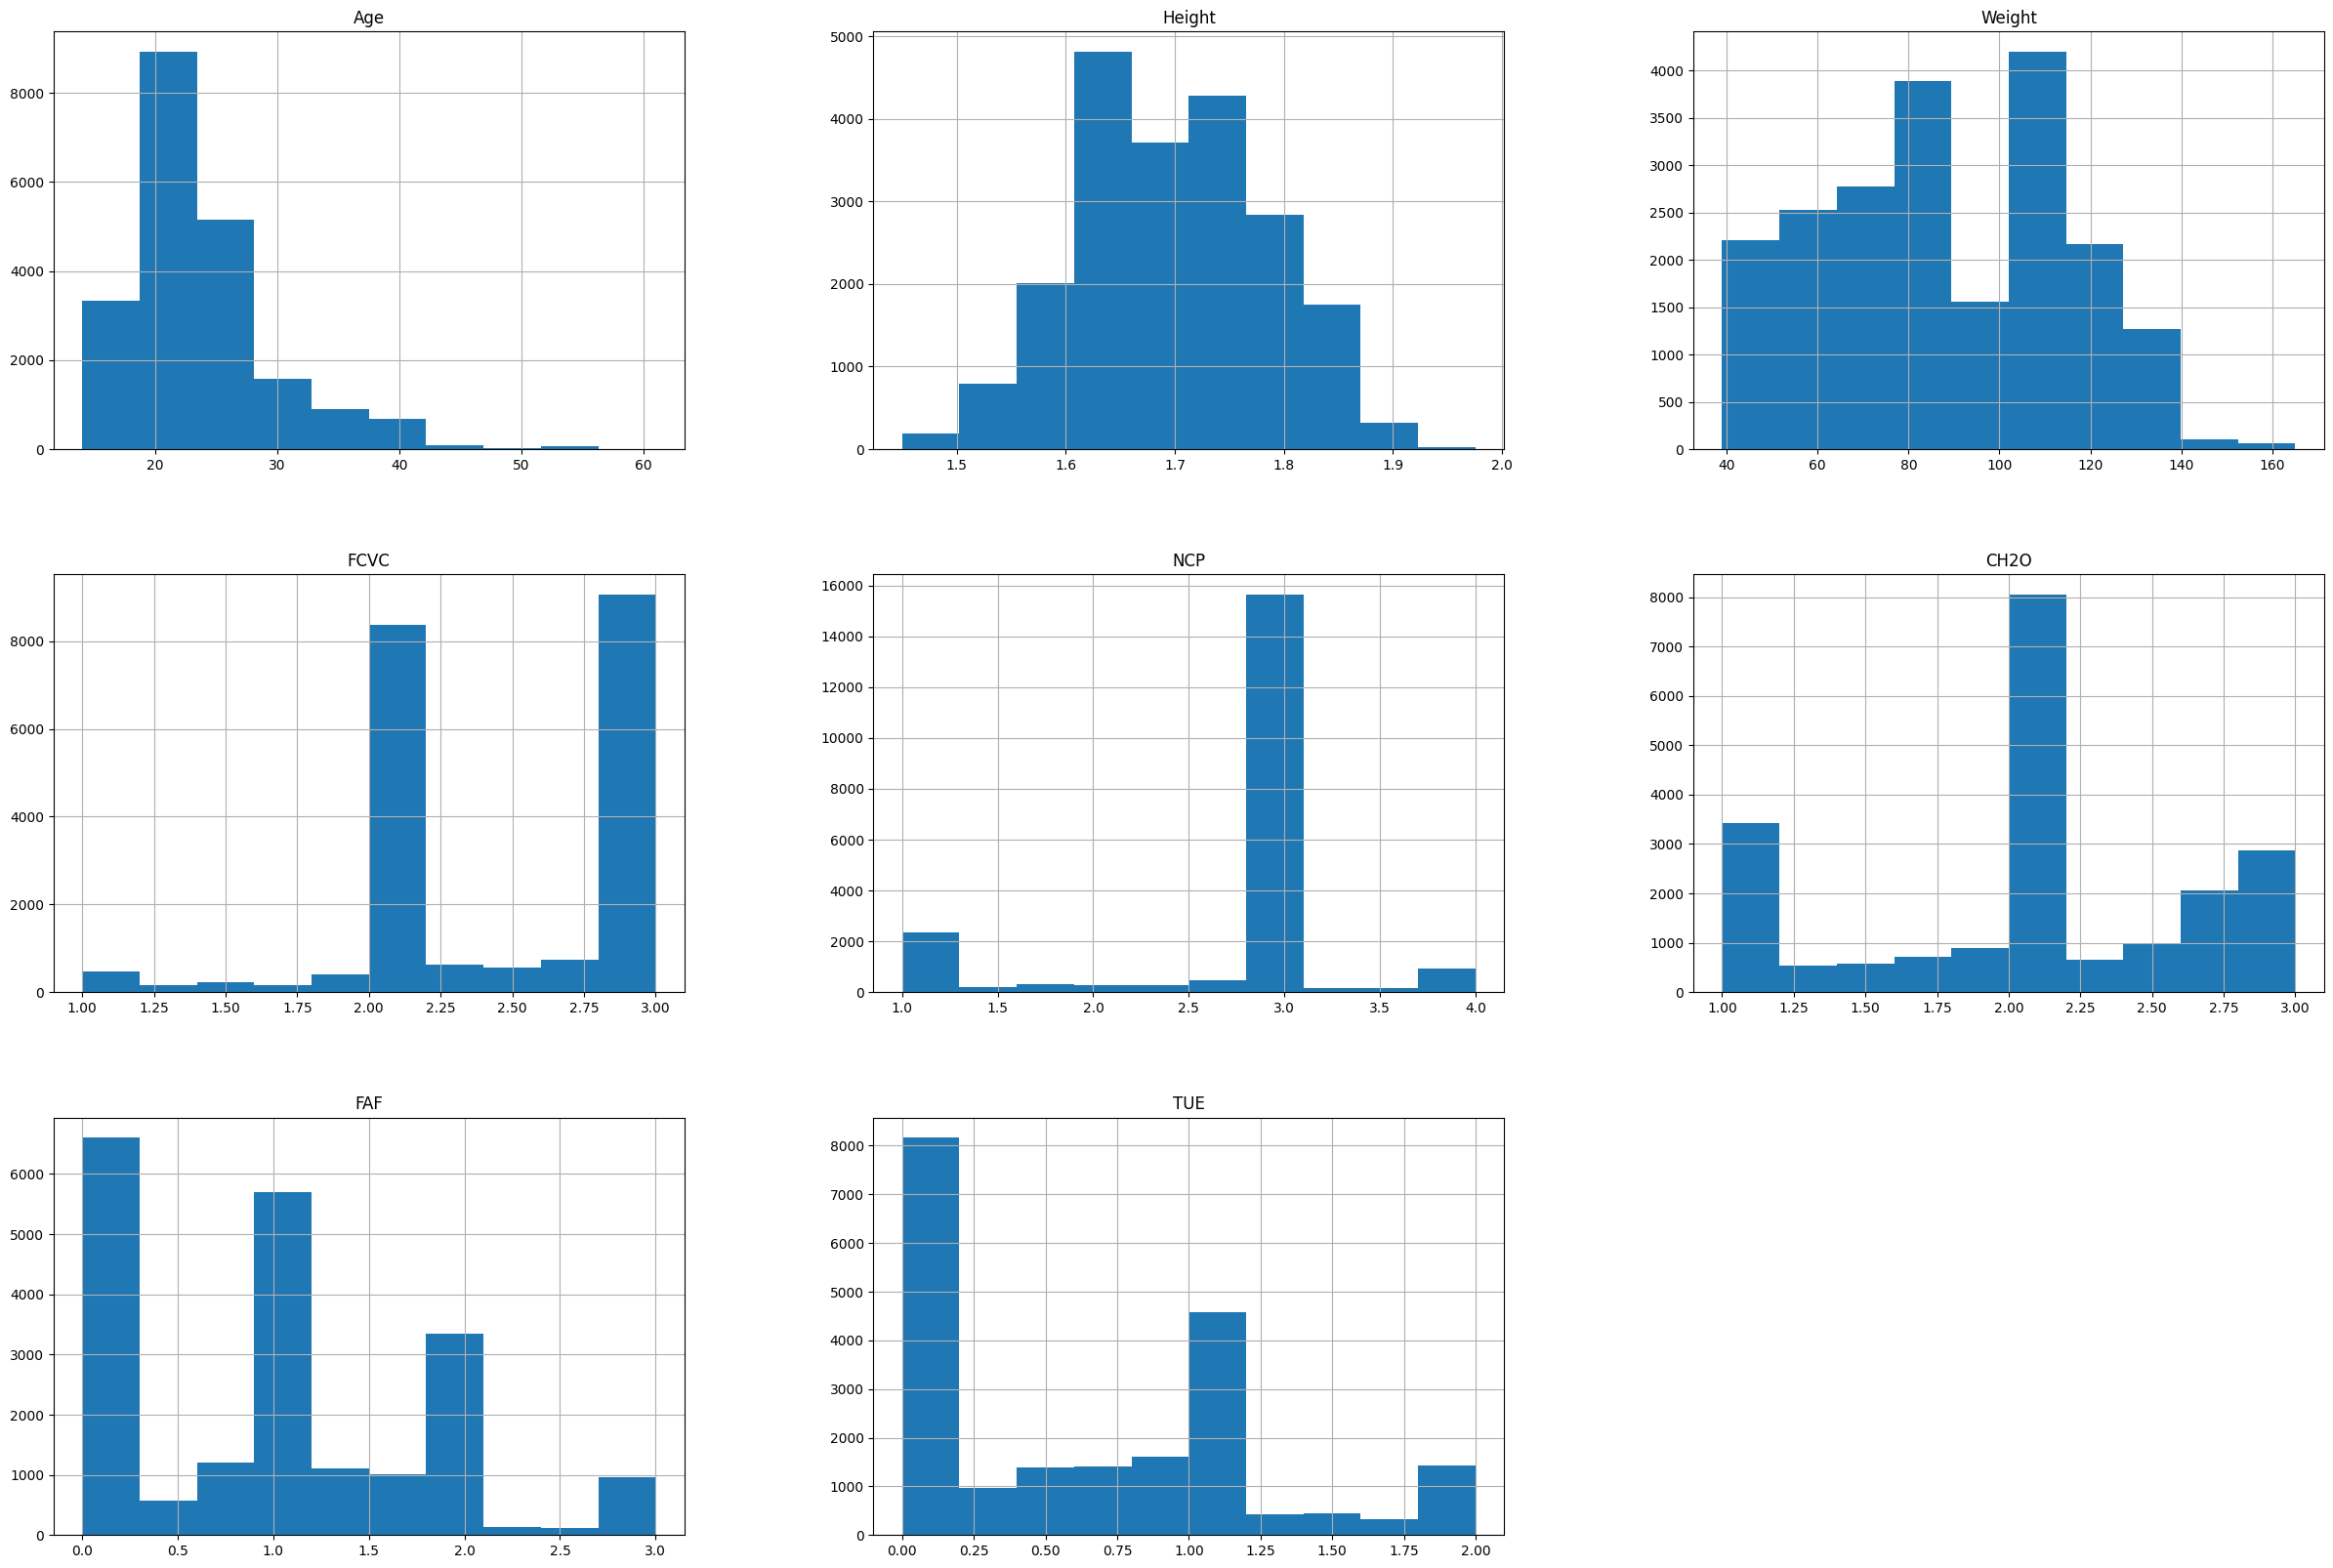

In [7]:
# Get numerical columns
numerical_columns = df_train.drop('id', axis=1).select_dtypes(include=['number']).columns.tolist()

df_train[numerical_columns].hist(figsize=(30, 20))

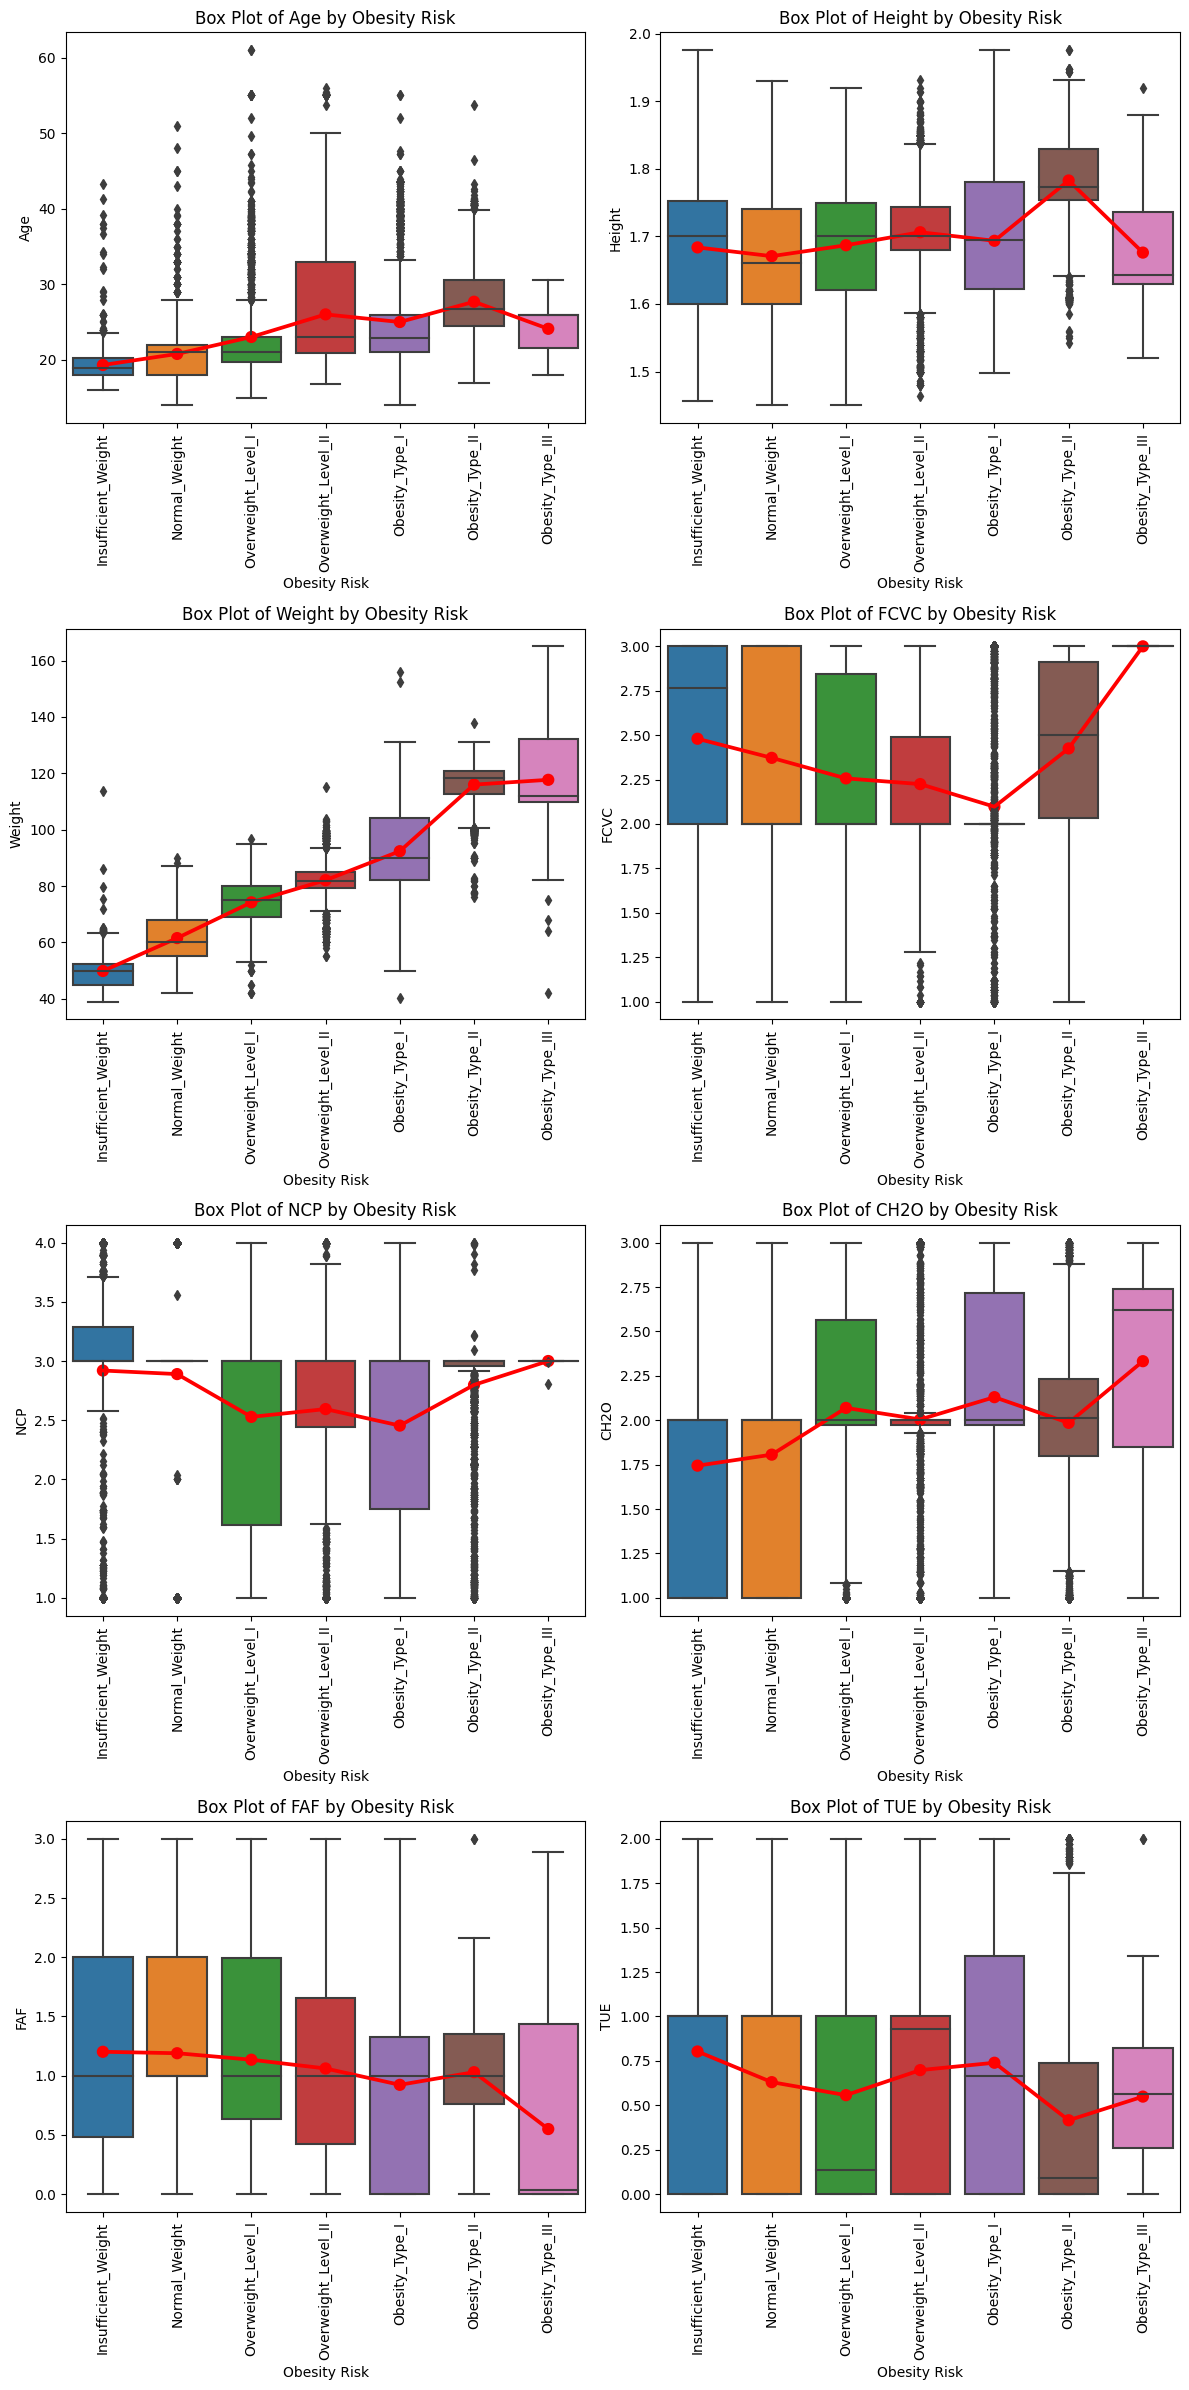

In [8]:

# Calculate number of rows and columns for subplots
num_plots = len(numerical_columns)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)

# Create subplots with specified height ratios
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 6), 
                         gridspec_kw={'height_ratios': [4] * num_rows})

# Plot box plots for each numerical column
for ax, column in zip(axes.flatten(), numerical_columns):
    sns.boxplot(x="NObeyesdad", y=column, data=df_train, ax=ax,order=mean_weights)
    sns.pointplot(x="NObeyesdad", y=column, data=df_train, ax=ax, color='red', markers='o', linestyles='-', errorbar=None, order=mean_weights)
    ax.set_title(f'Box Plot of {column} by Obesity Risk')
    ax.set_xlabel('Obesity Risk')
    ax.set_ylabel(column)
    ax.tick_params(axis='x', rotation=90)
    
plt.tight_layout()
plt.show()

From the Boxplot, you can see that the distribution varies at given numerical columns. Breakdown:

1) Age, height, CH2O: Mean and median increase for Obesity  levels

2) Weight: As predicted from out heuristics, Weight mean and median increase for Obesity levels

3) FCVC and NCP: Mean and median for FCVC and NCP have no correlation with Obesity levels

4) FAF and TUE: Mean for FAT and TUE  decreases for Obesity  levels.

From these we can ascertain that there are relations between features and Obesity levels.

Next, we check for correlation between features. 

<Axes: >

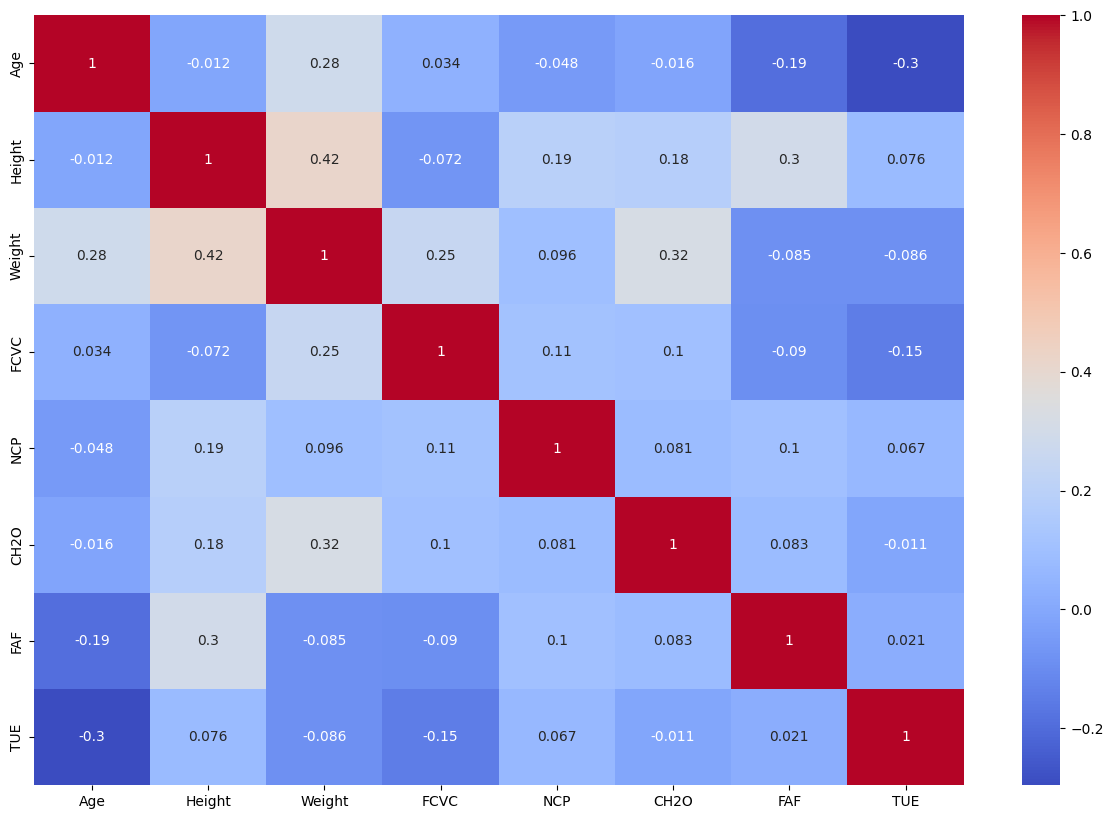

In [9]:
plt.figure(figsize=(15, 10))
data = df_train[numerical_columns]
sns.heatmap(data.corr(), cmap='coolwarm', annot=True)

We can see that there is high correlation between  FAF and height(0.3), Height and weight(0.42), weight and CH20(0.32)

ANalysis for non-numerical features

In [10]:
non_numerical_cols=df_train.drop('id', axis=1).select_dtypes(exclude=['number']).columns.tolist()

In [11]:
for col in non_numerical_cols:
    print(col, ": ", df_train[col].unique())

Gender :  ['Male' 'Female']
family_history_with_overweight :  ['yes' 'no']
FAVC :  ['yes' 'no']
CAEC :  ['Sometimes' 'Frequently' 'no' 'Always']
SMOKE :  ['no' 'yes']
SCC :  ['no' 'yes']
CALC :  ['Sometimes' 'no' 'Frequently']
MTRANS :  ['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
NObeyesdad :  ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']
